In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

import nltk

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix


from nlp_classification.environment_reference import EnvironmentReference
from nlp_classification.fill_functions import FeatureSelector, Cleaner, Lemmatizer


from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

Необходимо классифицировать сообщения на предмет того, из какого чата они были взяты.
Датасет представляет собой сообщения участников двух публичных чатов:
- Чат по Python (label=0)
- Чат по Data Science (label=1)


### Задачи:
1. Сделать предобработку текстов
2. Предложить модель классификации, метрики.
3. Объяснить их выбор (достоинства/недостатки).
4. Сделать выводы по работе модели(ей) (достоинства/недостатки),
а также проблемы, с которыми вы или ваша модель столкнулась.

### Загрузка данных

In [13]:
load_dotenv()

data = pd.read_csv(os.getenv(EnvironmentReference.RESEARCH_DATA_PATH))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12404 entries, 0 to 12403
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12404 non-null  object
 1   label   12404 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 193.9+ KB


Посмотрим на баланс класса

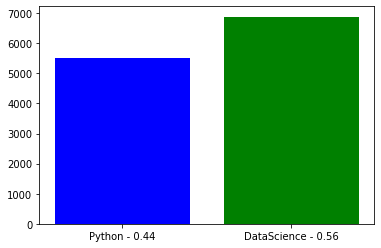

In [14]:
group_data = data.groupby('label').describe()
python_norm = round(data['label'].value_counts(normalize=True)[0],2)
ds_norm = round(data['label'].value_counts(normalize=True)[1],2)

plt.bar(f'Python - {python_norm}',group_data['text']['count'][0],
        label = 'Python', color = 'blue')
plt.bar(f'DataScience - {ds_norm}',group_data['text']['count'][1],
        label = 'DataScience', color = 'green')
plt.show()

Выборка имеет хороший баланс лейблов. На самом деле в подобных задачах(векторизации) плохая
балансировка не является чем-то неразрешимым.

### Преобработка текста

Для предобработки текста были реализованы классы Cleaner(очистка текста) и Lemmatizer(лемматизация).
Из библиотеки nltk были подгружены стоп-слова для дальнейшего удаления их из текста,
они не несут смысловой нагрузки и лишь вносят шум + нагружают модель.

In [15]:
# Подгрузим стоп-слова
# Далее в классе Cleaner будут подгружены именно русские стоп-слова
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mahh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Создадим пайплайны для классификаторов:
1. MultinomialNB
2. SGDClassifier
3. LogisticRegression
4. RandomForestClassifier
5. CatBoostClassifier
6. KNeighborsClassifier

P.S. CatBoostClassifier очень долго обучается, к тому-же без тонких настроек он дает самую плохую метрику из всех
представленных классификаторов. Мой ноутбук будет очень долго подбирать параметры по Grid, вынужден отказаться
в силу быстродействия выполнения. При этом я не отрицаю что возможно при должных настройках он покажет высокие результаты

In [16]:
classifier_1 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                   strip_accents='unicode',
                                                   analyzer='word', # аналитика по словам
                                                   token_pattern=r'\w{1,}', # выдергиваем разделители
                                                # длина ngram(ngram - смотрим на последовательности слов длиной 1 с шагом 1)
                                                   ngram_range=(1, 1),
                                                   max_features=10000)),
                         ('clf', MultinomialNB())])

classifier_2 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3))])


classifier_3 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', LogisticRegression(penalty='l2',C=2))])

classifier_4 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', RandomForestClassifier())])

classifier_6 = Pipeline([('selector', FeatureSelector(column='text')),
                         ('cleaner', Cleaner(column='text')),
                         ('lemma', Lemmatizer(column='text')),
                         ('tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)),
                         ('clf', KNeighborsClassifier(n_neighbors=100))])


Разобьем данные на train/test с использованием стратификации

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', 1),
                                                    data['label'],
                                                    random_state=42,
                                                    stratify=data['label'])

Проверю баланс в обучащей и тестовой выборках

In [18]:
print(f'Train:\n{y_train.value_counts(normalize=True)}')
print(f'Test:\n{y_test.value_counts(normalize=True)}')

Train:
1    0.55509
0    0.44491
Name: label, dtype: float64
Test:
1    0.554982
0    0.445018
Name: label, dtype: float64


#### Запустим кросс-валидацию на 4-х фолдах
В кач-ве метрики проверки качеcтва возьму площадь под кривой ROC

In [19]:
%%time

cv_scores_1 = cross_val_score(classifier_1, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_1 = np.mean(cv_scores_1)
print('MultinomialNB CV score is {}'.format(cv_score_1))

cv_scores_2 = cross_val_score(classifier_2, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_2 = np.mean(cv_scores_2)
print('SGDClassifier CV score is {}'.format(cv_score_2))

cv_scores_3 = cross_val_score(classifier_3, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_3 = np.mean(cv_scores_3)
print('LogisticRegression CV score is {}'.format(cv_score_3))

cv_scores_4 = cross_val_score(classifier_4, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_4 = np.mean(cv_scores_4)
print('RandomForestClassifier CV score is {}'.format(cv_score_4))

cv_scores_6 = cross_val_score(classifier_6, X_train, y_train, cv=4, scoring='roc_auc')
cv_score_6 = np.mean(cv_scores_6)
print('KNeighborsClassifier CV score is {}'.format(cv_score_6))

MultinomialNB CV score is 0.8744349871627434
SGDClassifier CV score is 0.8551020431852632
LogisticRegression CV score is 0.8559135310199122
RandomForestClassifier CV score is 0.8080429673190719
KNeighborsClassifier CV score is 0.8216219867543592
CPU times: user 2min 46s, sys: 3.97 s, total: 2min 50s
Wall time: 2min 47s


Удивительно, но без тонких настроек MultinomialNB дает самый лучший результат на кросс-валидации.
Попробую подобрать порог для каждой модели и посмотрим на метрики.

Для этого обучу все классификаторы и получу предикты

In [20]:
%%time

classifier_1.fit(X_train, y_train)
y_score_1 = classifier_1.predict_proba(X_test)[:, 1]

classifier_2.fit(X_train, y_train)
y_score_2 = classifier_2.predict_proba(X_test)[:, 1]

classifier_3.fit(X_train, y_train)
y_score_3 = classifier_3.predict_proba(X_test)[:, 1]

classifier_4.fit(X_train, y_train)
y_score_4 = classifier_4.predict_proba(X_test)[:, 1]

classifier_6.fit(X_train, y_train)
y_score_6 = classifier_6.predict_proba(X_test)[:, 1]

CPU times: user 57 s, sys: 1.5 s, total: 58.5 s
Wall time: 57.7 s


In [21]:
# Найдем точность, полноту и порог для каждого классификатора
precision_1, recall_1, threshold_1 = precision_recall_curve(y_test.values, y_score_1)
precision_2, recall_2, threshold_2 = precision_recall_curve(y_test.values, y_score_2)
precision_3, recall_3, threshold_3 = precision_recall_curve(y_test.values, y_score_3)
precision_4, recall_4, threshold_4 = precision_recall_curve(y_test.values, y_score_4)
precision_6, recall_6, threshold_6 = precision_recall_curve(y_test.values, y_score_6)

# Найдем F-меру для каждого классификатора
f_score_1 = (2*precision_1 * recall_1)/(precision_1 + recall_1)
f_score_2 = (2*precision_2 * recall_2)/(precision_2 + recall_2)
f_score_3 = (2*precision_3 * recall_3)/(precision_3 + recall_3)
f_score_4 = (2*precision_4 * recall_4)/(precision_4 + recall_4)
f_score_6 = (2*precision_6 * recall_6)/(precision_6 + recall_6)

# Найдем индекс максимального значения F-меры. При этом эти же индексы будут принадлежать оптимальным значениям
# точности, полноты и порога
ix1 = np.argmax(f_score_1)
ix2 = np.argmax(f_score_2)
ix3 = np.argmax(f_score_3)
ix4 = np.argmax(f_score_4)
ix6 = np.argmax(f_score_6)

roc_score_1 = roc_auc_score(y_test, y_score_1)
roc_score_2 = roc_auc_score(y_test, y_score_2)
roc_score_3 = roc_auc_score(y_test, y_score_3)
roc_score_4 = roc_auc_score(y_test, y_score_4)
roc_score_6 = roc_auc_score(y_test, y_score_6)

In [22]:
pd.DataFrame(data = [[f_score_1[ix1],roc_score_1,precision_1[ix1],recall_1[ix1],threshold_1[ix1]],
                    [f_score_2[ix2],roc_score_2, precision_2[ix2],recall_2[ix2],threshold_2[ix2]],
                    [f_score_3[ix3],roc_score_3,precision_3[ix3],recall_3[ix3],threshold_3[ix3]],
                    [f_score_4[ix4],roc_score_4,precision_4[ix4],recall_4[ix4],threshold_4[ix4]],
                    [f_score_6[ix6],roc_score_6,precision_6[ix6],recall_6[ix6],threshold_6[ix6]]],
            index = ['MultinomialNB','SGDClassifier','LogReg','RFC','KNeighborsClassifier'],
            columns = ['F_score','ROC-AUC','Precision','Recall','Threshold'])

,F_score,ROC-AUC,Precision,Recall,Threshold
MultinomialNB,0.837772,0.885679,0.780060,0.904707,0.472355
SGDClassifier,0.821102,0.864438,0.745731,0.913422,0.459479
LogReg,0.822509,0.867737,0.751201,0.908774,0.432340
RFC,0.794126,0.819029,0.734684,0.864033,0.441834
KNeighborsClassifier,0.805728,0.839107,0.753030,0.866357,0.530000


По соотноению сложности и эффективности MultinomialNB выигрывает.

Зная как он работает, могу предположить, что для решения конкретной задачи связь между словами(с которой алгоритм работает плохо)
не так важна. Возможно так оно и есть - сленговые слова тематики программирования встречаются в обоих классах,
но в чатике DS встречаются слова с сильным уклоном в математику/сленговые выражения DS,
что явно свидетельствует о принадлежности к данному классу.

Странно, думал это будет SGD, но имеем что имеем.
Попробуем улучшить алгоритм путем подбора параметров по сетке.


In [24]:
parameters = {
    'clf__alpha':[0, 0.01, 0.1, 0.5, 1.2],
    'clf__fit_prior': [True, False],
    'tfidf__strip_accents':['ascii', 'unicode', None],
    'tfidf__ngram_range':[(1,1), (2,3), (3,4)]
}

model = GridSearchCV(classifier_1, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)

print(f'Best score and parameter combination:\n{model.best_score_, model.best_params_}')

KeyboardInterrupt: 

Построй облако слов для наглядности
